In [1]:
# Cell 1: Initial setup and library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
import random
import os
import pickle
from scipy.sparse import save_npz, csr_matrix

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("Libraries imported successfully")

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/My Drive/MovieRecommendationSystem'  # Change as needed
    print("Google Drive mounted")
except:
    BASE_PATH = '.'  # Use current directory if not in Colab
    print("Not running in Colab, using local directory")

NumPy version: 2.0.2
Pandas version: 2.2.2
Libraries imported successfully
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted


In [3]:
# Cell 2: Load the dataset
# Update this path to where your dataset is stored
file_path = '/content/drive/My Drive/MovieRecommendationSystem/movies2024.csv'  # Update this with your actual path
movies_df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset Shape: {movies_df.shape}")
print("\nDataset Information:")
movies_df.info()

# Check for missing values
print("\nMissing Values:")
print(movies_df.isnull().sum())

# Display first few rows
print("\nFirst 5 rows:")
print(movies_df.head())

Dataset Shape: (9000, 9)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MovieID      9000 non-null   int64  
 1   Title        9000 non-null   object 
 2   Popularity   9000 non-null   float64
 3   Overview     8934 non-null   object 
 4   Genres       8928 non-null   object 
 5   Actors       8906 non-null   object 
 6   Directors    8946 non-null   object 
 7   VoteAverage  9000 non-null   float64
 8   ReleaseYear  8968 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 632.9+ KB

Missing Values:
MovieID         0
Title           0
Popularity      0
Overview       66
Genres         72
Actors         94
Directors      54
VoteAverage     0
ReleaseYear    32
dtype: int64

First 5 rows:
   MovieID                 Title  Popularity  \
0   533535  Deadpool & Wolverine    5948.017   
1  1022789        

In [4]:
# Cell 3: Data Cleaning - Handle missing values
# Replace missing values in numeric columns with appropriate values
numeric_cols = ['Popularity', 'VoteAverage', 'ReleaseYear']
for col in numeric_cols:
    # Replace missing values with median for numeric columns
    if movies_df[col].isnull().sum() > 0:
        median_val = movies_df[col].median()
        movies_df[col] = movies_df[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val}")

# For text fields, replace with appropriate placeholder
text_cols = ['Title', 'Overview', 'Genres', 'Actors', 'Directors']
for col in text_cols:
    # Replace missing text with "Unknown"
    if movies_df[col].isnull().sum() > 0:
        movies_df[col] = movies_df[col].fillna("Unknown")
        print(f"Filled {col} missing values with 'Unknown'")

# Verify missing values are handled
print("\nRemaining Missing Values:")
print(movies_df.isnull().sum())

Filled ReleaseYear missing values with median: 2012.0
Filled Overview missing values with 'Unknown'
Filled Genres missing values with 'Unknown'
Filled Actors missing values with 'Unknown'
Filled Directors missing values with 'Unknown'

Remaining Missing Values:
MovieID        0
Title          0
Popularity     0
Overview       0
Genres         0
Actors         0
Directors      0
VoteAverage    0
ReleaseYear    0
dtype: int64


In [5]:
# Cell 4: Feature Engineering - Process Genre Data
# Extract genres into a list format
movies_df['GenresList'] = movies_df['Genres'].str.split('|')

# Count number of genres per movie
movies_df['GenreCount'] = movies_df['GenresList'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Create a function to get all unique genres
def get_all_genres(genres_list):
    all_genres = []
    for genres in genres_list:
        if isinstance(genres, list):
            all_genres.extend(genres)
    return list(set(all_genres))

all_genres = get_all_genres(movies_df['GenresList'])
print(f"Total unique genres: {len(all_genres)}")
print(f"Unique genres: {sorted(all_genres)}")

# Create genre distribution
genre_counts = {}
for genres in movies_df['GenresList']:
    if isinstance(genres, list):
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

# Convert to DataFrame for visualization
genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])
genre_df = genre_df.sort_values('Count', ascending=False).reset_index(drop=True)

# Display top genres
print("\nTop 10 genres:")
print(genre_df.head(10))

Total unique genres: 1940
Unique genres: ['Action', 'Action, Adventure', 'Action, Adventure, Animation', 'Action, Adventure, Animation, Comedy, Family', 'Action, Adventure, Animation, Comedy, Fantasy', 'Action, Adventure, Animation, Drama, Family, Fantasy', 'Action, Adventure, Animation, Family', 'Action, Adventure, Animation, Family, Comedy', 'Action, Adventure, Animation, Family, Fantasy', 'Action, Adventure, Animation, Fantasy, Science Fiction', 'Action, Adventure, Animation, Science Fiction, Drama', 'Action, Adventure, Animation, War, Science Fiction', 'Action, Adventure, Comedy', 'Action, Adventure, Comedy, Crime', 'Action, Adventure, Comedy, Crime, Drama, Thriller', 'Action, Adventure, Comedy, Crime, Thriller', 'Action, Adventure, Comedy, Drama, Fantasy, Animation', 'Action, Adventure, Comedy, Family', 'Action, Adventure, Comedy, Family, Crime', 'Action, Adventure, Comedy, Family, Fantasy, Science Fiction', 'Action, Adventure, Comedy, Family, Science Fiction', 'Action, Adventure,

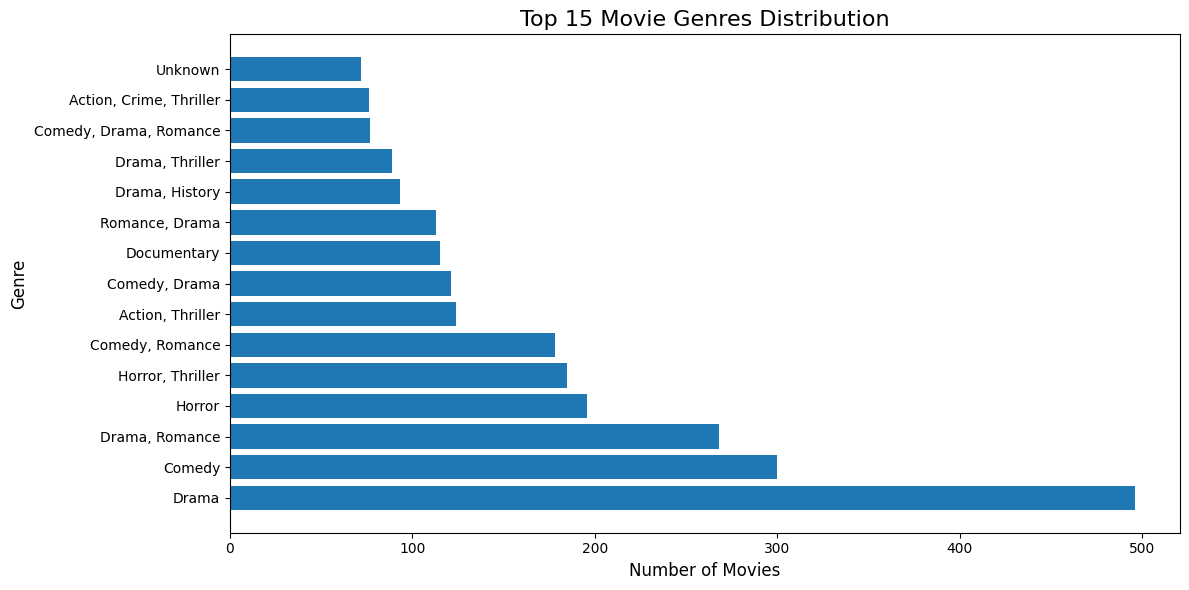

In [6]:
# Cell 5: Data Visualization - Genre Distribution
plt.figure(figsize=(12, 6))
plt.barh(genre_df.head(15)['Genre'], genre_df.head(15)['Count'])
plt.title('Top 15 Movie Genres Distribution', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

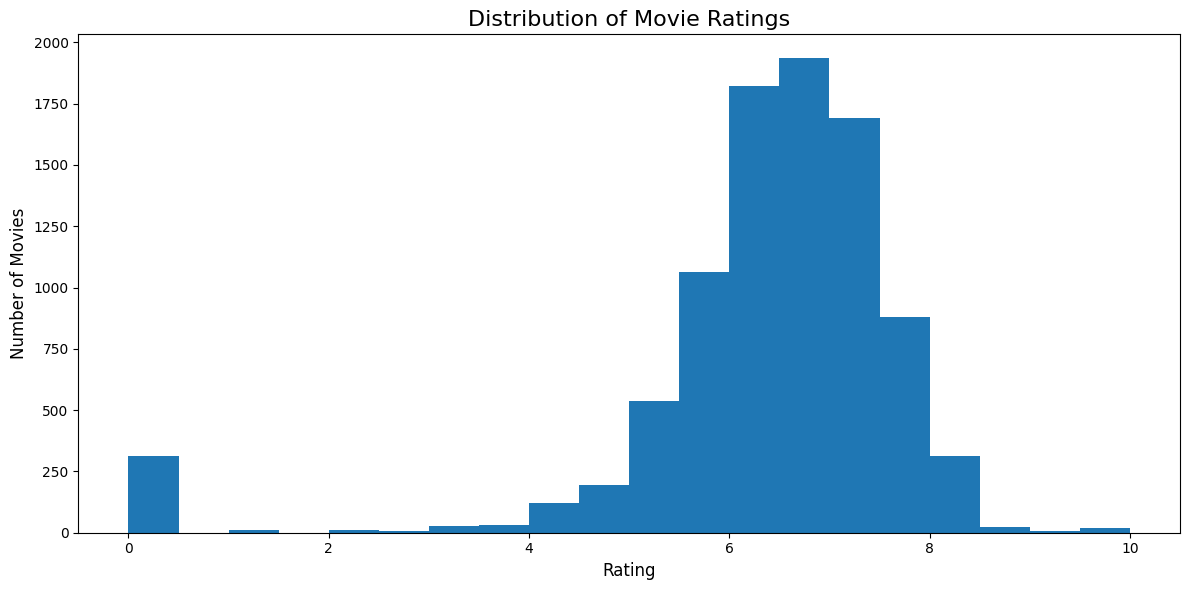

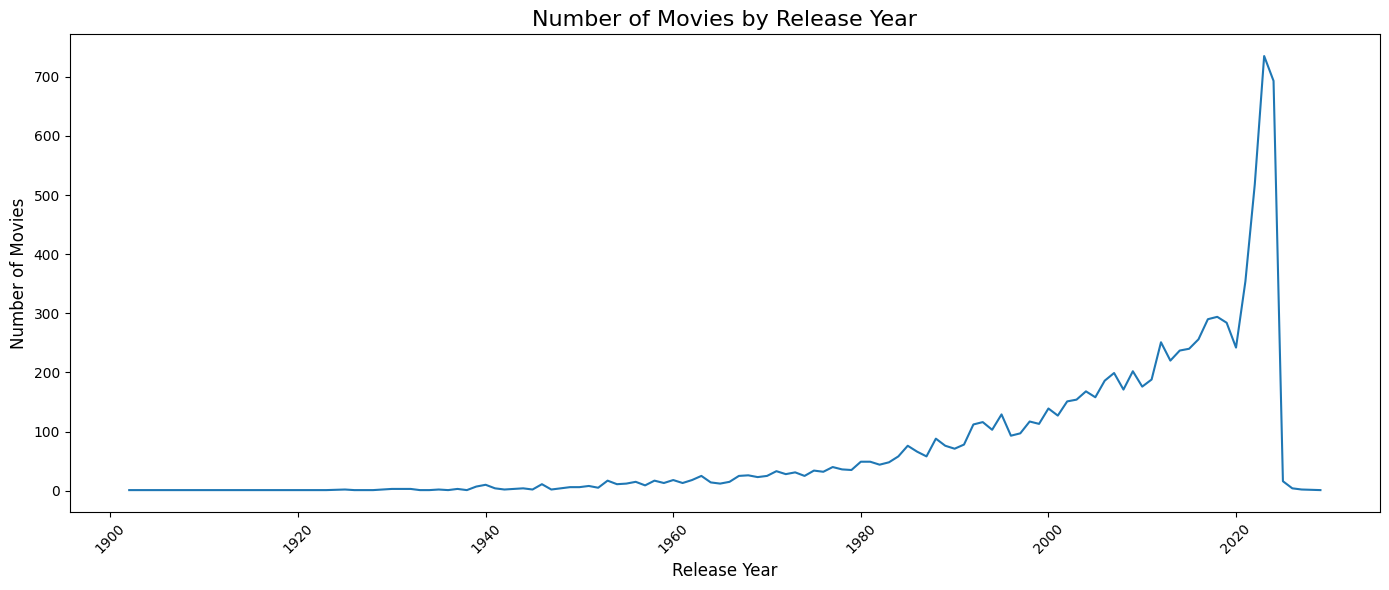

In [7]:
# Cell 6: Data Visualization - Rating Distribution
# Rating distribution
plt.figure(figsize=(12, 6))
plt.hist(movies_df['VoteAverage'].dropna(), bins=20)
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.tight_layout()
plt.show()

# Movies by release year
plt.figure(figsize=(14, 6))
year_counts = movies_df['ReleaseYear'].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values)
plt.title('Number of Movies by Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Cell 7: Process Text Data - Create TF-IDF Features (OPTIMIZED)
# Clean and prepare the overview text
movies_df['Overview_Clean'] = movies_df['Overview'].fillna('').str.lower()

# Create TF-IDF features from movie overviews
# OPTIMIZATION: Reduced max_features from 5000 to 2000 to save space
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['Overview_Clean'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Features extracted: {len(tfidf.get_feature_names_out())}")

# Save feature names for future reference
tfidf_feature_names = tfidf.get_feature_names_out()
print("Sample TF-IDF features:", tfidf_feature_names[:20])

TF-IDF Matrix Shape: (9000, 2000)
Features extracted: 2000
Sample TF-IDF features: ['000' '10' '11' '12' '13' '14' '15' '16' '17' '1970s' '1980s' '19th' '20'
 '25' '50' 'abandoned' 'abducted' 'abilities' 'ability' 'able']


In [9]:
# Cell 8: Data Preprocessing - Encode Genres for Model Input
# One-hot encode genres for modeling
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies_df['GenresList'].fillna('').apply(lambda x: x if isinstance(x, list) else []))

# Create a DataFrame with genre encodings
genre_df_encoded = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# Display the first few rows of encoded genres
print("One-hot encoded genres (first 5 rows, first 10 genres):")
print(genre_df_encoded.iloc[:5, :10])

# Add the movie IDs to keep track of the encoding
genre_df_encoded['MovieID'] = movies_df['MovieID'].values

print(f"Genre encoding shape: {genre_df_encoded.shape}")

One-hot encoded genres (first 5 rows, first 10 genres):
   Action  Action, Adventure  Action, Adventure, Animation  \
0       0                  0                             0   
1       0                  0                             0   
2       0                  0                             0   
3       0                  0                             0   
4       0                  0                             0   

   Action, Adventure, Animation, Comedy, Family  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Action, Adventure, Animation, Comedy, Fantasy  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4   

In [10]:
# Cell 9: Content-Based Filtering - OPTIMIZED Similarity Calculation
# Calculate the cosine similarity for a smaller subset of movies to reduce memory usage
# OPTIMIZATION: Use a sample of movies for the full similarity matrix
SAMPLE_SIZE = min(3000, len(movies_df))  # Use at most 3000 movies for full similarity matrix
sample_indices = np.random.choice(len(movies_df), SAMPLE_SIZE, replace=False)

# Calculate similarity matrix on the sample
sample_tfidf_matrix = tfidf_matrix[sample_indices]
cosine_sim_overview_sample = cosine_similarity(sample_tfidf_matrix, sample_tfidf_matrix)

print(f"Sample cosine similarity matrix shape: {cosine_sim_overview_sample.shape}")

# Create a more memory-efficient approach for finding similar movies
# Instead of storing the full matrix, store only the top 50 similar movies for each movie
def compute_top_similarities(idx, n=50):
    """Compute top N similar movies for a given movie index"""
    # Get the movie's TF-IDF vector
    movie_vec = tfidf_matrix[idx:idx+1]

    # Calculate similarity with all other movies
    sims = cosine_similarity(movie_vec, tfidf_matrix).flatten()

    # Get top N similar movies (excluding self)
    sim_indices = sims.argsort()[::-1][1:n+1]
    sim_scores = sims[sim_indices]

    return list(zip(sim_indices, sim_scores))

# Test the function with a sample movie
sample_idx = 100  # Just using the 100th movie as an example
sample_movie = movies_df['Title'].iloc[sample_idx]
print(f"Getting content-based recommendations for: {sample_movie}")
similar_movies = compute_top_similarities(sample_idx)

# Display top 5 similar movies
print("\nTop 5 similar movies:")
for idx, score in similar_movies[:5]:
    print(f"{movies_df['Title'].iloc[idx]} - Similarity: {score:.4f}")

Sample cosine similarity matrix shape: (3000, 3000)
Getting content-based recommendations for: The Last Breath

Top 5 similar movies:
Bait - Similarity: 0.3364
47 Meters Down: Uncaged - Similarity: 0.3169
Fog City - Similarity: 0.3021
Kuch Kuch Hota Hai - Similarity: 0.2587
Kuch Kuch Hota Hai - Similarity: 0.2587


In [11]:
# Cell 10: Content-Based Filtering - Genre Similarity (OPTIMIZED)
# Use the genre encodings to compute genre-based recommendations
# OPTIMIZATION: Create a sparse similarity function instead of full matrix

def compute_genre_similarity(idx, n=50):
    """Compute genre-based similarity for a given movie index"""
    # Get the movie's genre vector (excluding MovieID column)
    movie_genres = genre_df_encoded.iloc[idx, :-1].values.reshape(1, -1)

    # Calculate similarity with all other movies
    genre_sims = cosine_similarity(
        movie_genres,
        genre_df_encoded.iloc[:, :-1].values
    ).flatten()

    # Get top N similar movies (excluding self)
    sim_indices = genre_sims.argsort()[::-1][1:n+1]
    sim_scores = genre_sims[sim_indices]

    return list(zip(sim_indices, sim_scores))

# Test the genre similarity function
print(f"Getting genre-based recommendations for: {sample_movie}")
genre_similar_movies = compute_genre_similarity(sample_idx)

# Display top 5 genre-similar movies
print("\nTop 5 genre-similar movies:")
for idx, score in genre_similar_movies[:5]:
    print(f"{movies_df['Title'].iloc[idx]} - Similarity: {score:.4f}")

# Create a hybrid similarity function that combines content and genre
def compute_hybrid_similarity(idx, content_weight=0.6, genre_weight=0.4, n=50):
    """Compute hybrid content-genre similarity for a given movie index"""
    # Get content-based similarities
    content_sims = compute_top_similarities(idx, n=100)

    # Get genre-based similarities
    genre_sims = compute_genre_similarity(idx, n=100)

    # Create dictionaries for easier manipulation
    content_dict = dict(content_sims)
    genre_dict = dict(genre_sims)

    # Combine the similarities
    hybrid_scores = {}

    # Process all indices in both dictionaries
    all_indices = set(content_dict.keys()).union(set(genre_dict.keys()))

    for i in all_indices:
        # Get scores (default 0 if not in the dictionary)
        content_score = content_dict.get(i, 0)
        genre_score = genre_dict.get(i, 0)

        # Calculate weighted score
        hybrid_scores[i] = (content_weight * content_score) + (genre_weight * genre_score)

    # Sort by score and get top N
    sorted_scores = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Test the hybrid function
print(f"Getting hybrid recommendations for: {sample_movie}")
hybrid_recommendations = compute_hybrid_similarity(sample_idx)

# Display top 5 hybrid recommendations
print("\nTop 5 hybrid recommendations:")
for idx, score in hybrid_recommendations[:5]:
    print(f"{movies_df['Title'].iloc[idx]} - Similarity: {score:.4f}")

Getting genre-based recommendations for: The Last Breath

Top 5 genre-similar movies:
Dead Calm - Similarity: 1.0000
Cold Meat - Similarity: 1.0000
Truth or Dare - Similarity: 1.0000
Alone - Similarity: 1.0000
Jessabelle - Similarity: 1.0000
Getting hybrid recommendations for: The Last Breath

Top 5 hybrid recommendations:
Kristy - Similarity: 0.4971
Something in the Water - Similarity: 0.4000
Alone - Similarity: 0.4000
The Remaining - Similarity: 0.4000
The Vatican Tapes - Similarity: 0.4000


In [12]:
# Cell 11: Simulated User Ratings Data Generation
# Set a random seed for reproducibility
np.random.seed(42)

# Create a simulated user-rating dataset
num_users = 100  # Start with 100 simulated users
num_ratings_per_user = 20  # Each user rates 20 movies

# Create an empty list to store ratings
ratings_data = []

# Generate synthetic ratings
for user_id in range(1, num_users + 1):
    # Select random movies for this user to rate
    rated_movies = np.random.choice(movies_df['MovieID'].values, num_ratings_per_user, replace=False)

    for movie_id in rated_movies:
        # Generate a random rating (1-5 with half-star increments)
        # Weighted towards higher ratings for more popular movies
        movie_index = movies_df[movies_df['MovieID'] == movie_id].index[0]
        popularity = movies_df.loc[movie_index, 'Popularity']
        vote_avg = movies_df.loc[movie_index, 'VoteAverage']

        # Calculate a baseline rating influenced by the movie's average vote
        base_rating = max(1, min(5, vote_avg * 5 / 10))  # Convert 0-10 scale to 1-5

        # Add some random noise, slightly biased by popularity
        noise = np.random.normal(0, 0.5) + (popularity / 100)
        rating = max(1, min(5, base_rating + noise))

        # Round to nearest half-star
        rating = round(rating * 2) / 2

        # Add to ratings data
        ratings_data.append({
            'UserID': user_id,
            'MovieID': movie_id,
            'Rating': rating
        })

# Convert to DataFrame
ratings_df = pd.DataFrame(ratings_data)

print(f"Generated {len(ratings_df)} ratings for {num_users} users")
print("\nSample ratings:")
print(ratings_df.head())

# Basic stats about the ratings
print(f"\nRatings distribution:")
print(ratings_df['Rating'].value_counts().sort_index())

Generated 2000 ratings for 100 users

Sample ratings:
   UserID  MovieID  Rating
0       1   330483     3.5
1       1  1211307     4.0
2       1   287947     4.5
3       1     1103     4.0
4       1     8852     4.0

Ratings distribution:
Rating
1.0     40
1.5     29
2.0     62
2.5    152
3.0    351
3.5    514
4.0    452
4.5    237
5.0    163
Name: count, dtype: int64


In [13]:
# Cell 12: Collaborative Filtering - Matrix Factorization (OPTIMIZED)
# Use pivot_table to handle potential duplicates
user_movie_matrix = ratings_df.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating',
    aggfunc='mean',
    fill_value=0
)
print(f"User-Movie Matrix Shape: {user_movie_matrix.shape}")

# Split data into training and test sets
from sklearn.model_selection import train_test_split

# Convert ratings_df to a list of tuples for easier splitting
ratings_tuples = [
    (row['UserID'], row['MovieID'], row['Rating'])
    for _, row in ratings_df.iterrows()
]

# Split into train and test sets
train_data, test_data = train_test_split(ratings_tuples, test_size=0.2, random_state=42)

# Create training and test DataFrames
train_df = pd.DataFrame(train_data, columns=['UserID', 'MovieID', 'Rating'])
test_df = pd.DataFrame(test_data, columns=['UserID', 'MovieID', 'Rating'])

print(f"Training data: {len(train_df)} ratings")
print(f"Test data: {len(test_df)} ratings")

# Create the training user-movie matrix, again handling duplicates
train_matrix = train_df.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating',
    aggfunc='mean',
    fill_value=0
)

# OPTIMIZATION: Reduced number of components to save space
n_components = 30  # Reduced from 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(train_matrix)

# Get movie features
movie_features = svd.components_.T

print(f"User features shape: {user_features.shape}")
print(f"Movie features shape: {movie_features.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

User-Movie Matrix Shape: (100, 1747)
Training data: 1600 ratings
Test data: 400 ratings
User features shape: (100, 30)
Movie features shape: (1428, 30)
Explained variance ratio: 0.3660


In [14]:
# Cell 13: Collaborative Filtering Recommendations Function
def get_collaborative_recommendations(user_id, user_features, movie_features, movies_df, top_n=10, already_seen=None):
    """
    Get movie recommendations for a user using matrix factorization

    Args:
        user_id: ID of the user to get recommendations for
        user_features: User feature matrix from SVD
        movie_features: Movie feature matrix from SVD
        movies_df: DataFrame containing movie information
        top_n: Number of recommendations to return
        already_seen: List of movie IDs the user has already seen

    Returns:
        DataFrame with recommended movies and their predicted ratings
    """
    if already_seen is None:
        # Get the movies this user has already rated
        already_seen = ratings_df[ratings_df['UserID'] == user_id]['MovieID'].tolist()

    # Get user's feature vector (subtract 1 because user_ids start from 1)
    try:
        user_index = list(train_matrix.index).index(user_id)
        user_vec = user_features[user_index]
    except:
        print(f"User {user_id} not found in training data. Using average user.")
        user_vec = np.mean(user_features, axis=0)

    # Compute predicted ratings for all movies
    predicted_ratings = np.dot(user_vec, movie_features.T)

    # Create a mapping of movie column index to movie ID
    col_to_id = dict(enumerate(train_matrix.columns))

    # Create list of (movie_id, predicted_rating)
    predictions = [
        (col_to_id[i], predicted_ratings[i])
        for i in range(len(predicted_ratings))
        if col_to_id[i] not in already_seen
    ]

    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_predictions = predictions[:top_n]

    # Get movie details
    movie_ids = [p[0] for p in top_predictions]
    predicted_scores = [p[1] for p in top_predictions]

    # Create recommendation DataFrame
    recommendations = movies_df[movies_df['MovieID'].isin(movie_ids)].copy()

    # Add predicted rating
    rating_dict = dict(zip(movie_ids, predicted_scores))
    recommendations['PredictedRating'] = recommendations['MovieID'].map(rating_dict)

    # Sort by predicted rating
    recommendations = recommendations.sort_values('PredictedRating', ascending=False)

    return recommendations[['MovieID', 'Title', 'Genres', 'VoteAverage', 'PredictedRating']]

# Test collaborative filtering recommendations for a sample user
sample_user_id = train_matrix.index[0]  # Get first user from training data
user_seen_movies = ratings_df[ratings_df['UserID'] == sample_user_id]['MovieID'].tolist()
print(f"Sample user {sample_user_id} has rated {len(user_seen_movies)} movies")

cf_recommendations = get_collaborative_recommendations(
    sample_user_id,
    user_features,
    movie_features,
    movies_df
)
print(f"Collaborative filtering recommendations for User {sample_user_id}:")
print(cf_recommendations)

Sample user 1.0 has rated 20 movies
Collaborative filtering recommendations for User 1.0:
      MovieID                                  Title  \
8384    82696                           Hope Springs   
1804      426                                Vertigo   
7182   600583                   The Power of the Dog   
7791   600583                   The Power of the Dog   
6419   667257                      Impossible Things   
2026     5876                               The Mist   
8614   667257                      Impossible Things   
2741    58431        Pride and Prejudice and Zombies   
2555    58431        Pride and Prejudice and Zombies   
781    301528                            Toy Story 4   
3191    21191                             Sin Nombre   
5528  1192548  Hannah Waddingham: Home for Christmas   
3812  1192548  Hannah Waddingham: Home for Christmas   
8728  1121956                           Green Border   

                                             Genres  VoteAverage  \
8

In [15]:
# Cell 14: Add Regional Cinema Classifier
def classify_movie_region(movie_row):
    """
    Classify movies into regional cinema categories based on available information
    """
    title = str(movie_row['Title']).lower()
    actors = str(movie_row['Actors']).lower() if 'Actors' in movie_row else ""
    directors = str(movie_row['Directors']).lower() if 'Directors' in movie_row else ""
    overview = str(movie_row['Overview']).lower() if 'Overview' in movie_row else ""

    # Combined text for analysis
    combined_text = f"{title} {actors} {directors} {overview}"

    # Define keywords/patterns for different regional cinemas
    bollywood_patterns = ['bollywood', 'hindi', 'india', 'indian', 'mumbai', 'khan', 'kapoor', 'chopra', 'johar', 'bhatt']
    tollywood_patterns = ['telugu', 'tollywood', 'hyderabad', 'andhra', 'telangana', 'rajamouli', 'prabhas', 'allu', 'chiranjeevi']
    kollywood_patterns = ['tamil', 'kollywood', 'chennai', 'rajinikanth', 'vijay', 'ajith']

    # Check for regional cinema markers
    for pattern in bollywood_patterns:
        if pattern in combined_text:
            return "Bollywood"

    for pattern in tollywood_patterns:
        if pattern in combined_text:
            return "Tollywood"

    for pattern in kollywood_patterns:
        if pattern in combined_text:
            return "Kollywood"

    # Default to Hollywood (Western cinema) if no other patterns match
    return "Hollywood"

# Apply regional classification
if 'Region' not in movies_df.columns:
    print("Classifying movies by regional cinema...")
    movies_df['Region'] = movies_df.apply(classify_movie_region, axis=1)

    # Count movies by region
    region_counts = movies_df['Region'].value_counts()
    print(f"Movies by region: {dict(region_counts)}")

Classifying movies by regional cinema...
Movies by region: {'Hollywood': np.int64(8542), 'Bollywood': np.int64(328), 'Tollywood': np.int64(109), 'Kollywood': np.int64(21)}


In [16]:
# Cell 15: Context-aware recommendations - Mood-based filtering
def get_mood_based_recommendations(mood, movies_df, top_n=10):
    """
    Get recommendations based on user's current mood

    Args:
        mood: Current mood of the user (e.g., 'happy', 'sad', 'excited', 'relaxed')
        movies_df: DataFrame with movie information
        top_n: Number of recommendations to return

    Returns:
        DataFrame with mood-appropriate movie recommendations
    """
    # Define mood-to-genre mapping (based on common associations)
    mood_genres = {
        'happy': ['Comedy', 'Animation', 'Family', 'Adventure'],
        'sad': ['Drama', 'Romance', 'Music'],
        'excited': ['Action', 'Adventure', 'Science Fiction', 'Fantasy'],
        'relaxed': ['Documentary', 'History', 'TV Movie'],
        'tense': ['Thriller', 'Mystery', 'Crime'],
        'scared': ['Horror', 'Thriller'],
        'thoughtful': ['Drama', 'History', 'Documentary', 'War']
    }

    # Select genres for the given mood
    if mood not in mood_genres:
        print(f"Mood '{mood}' not recognized. Using default genres.")
        selected_genres = ['Comedy', 'Drama', 'Action']
    else:
        selected_genres = mood_genres[mood]

    print(f"Selected genres for mood '{mood}': {selected_genres}")

    # Find movies matching these genres
    matching_movies = []

    for idx, row in movies_df.iterrows():
        movie_genres = row['Genres'].split('|') if isinstance(row['Genres'], str) else []
        # Check if any of the movie's genres match the mood genres
        if any(genre in movie_genres for genre in selected_genres):
            # Add this movie to matching movies
            matching_movies.append({
                'MovieID': row['MovieID'],
                'Title': row['Title'],
                'Genres': row['Genres'],
                'VoteAverage': row['VoteAverage'],
                'Region': row['Region'] if 'Region' in row else 'Unknown',
                'MoodMatch': sum(1 for genre in movie_genres if genre in selected_genres) / len(movie_genres) if len(movie_genres) > 0 else 0
            })

    # Convert to DataFrame
    mood_recs = pd.DataFrame(matching_movies)

    # Sort by a combination of mood match and rating
    mood_recs['CombinedScore'] = (0.7 * mood_recs['MoodMatch']) + (0.3 * (mood_recs['VoteAverage'] / 10))
    mood_recs = mood_recs.sort_values('CombinedScore', ascending=False)

    return mood_recs.head(top_n)[['MovieID', 'Title', 'Genres', 'VoteAverage', 'MoodMatch']]

# Test mood-based recommendations
test_mood = 'excited'
mood_recommendations = get_mood_based_recommendations(test_mood, movies_df)
print(f"Movie recommendations for '{test_mood}' mood:")
print(mood_recommendations)

Selected genres for mood 'excited': ['Action', 'Adventure', 'Science Fiction', 'Fantasy']
Movie recommendations for 'excited' mood:
    MovieID                       Title           Genres  VoteAverage  \
69   666035                  Wanted Man           Action       10.000   
38    17809              Fist of Legend           Action        7.500   
59    17809              Fist of Legend           Action        7.500   
17    17654                  District 9  Science Fiction        7.446   
29     9461            Enter the Dragon           Action        7.419   
33  1064517          Fist of the Condor           Action        7.400   
11   842675      The Wandering Earth II  Science Fiction        7.200   
32   920258  The Immortal Wars: Rebirth  Science Fiction        7.125   
34    12481                The Big Boss           Action        7.113   
36    12481                The Big Boss           Action        7.113   

    MoodMatch  
69        1.0  
38        1.0  
59        1.0  


In [17]:
# Cell 16: Hidden Gems Recommendation
def get_hidden_gems(movies_df, popularity_threshold=20, rating_threshold=7.0, min_votes=5, top_n=10):
    """
    Identify hidden gems - highly rated movies with lower popularity

    Args:
        movies_df: DataFrame with movie information
        popularity_threshold: Max popularity score to be considered "hidden"
        rating_threshold: Min rating to be considered "gem"
        min_votes: Minimum number of votes to consider rating valid
        top_n: Number of recommendations to return

    Returns:
        DataFrame with hidden gem recommendations
    """
    # Filter for movies with good ratings but low popularity
    hidden_gems = movies_df[
        (movies_df['Popularity'] < popularity_threshold) &
        (movies_df['VoteAverage'] >= rating_threshold)
    ].copy()

    # Calculate a "gem score" based on how much the rating exceeds the threshold
    # and how far below the popularity threshold it is
    hidden_gems['GemScore'] = (
        (hidden_gems['VoteAverage'] - rating_threshold) / 3 +  # Rating component
        (1 - (hidden_gems['Popularity'] / popularity_threshold))  # Popularity component
    )

    # Sort by gem score
    hidden_gems = hidden_gems.sort_values('GemScore', ascending=False)

    return hidden_gems.head(top_n)[['MovieID', 'Title', 'Genres', 'VoteAverage', 'Popularity', 'GemScore']]

# Test hidden gems recommendations
hidden_gems = get_hidden_gems(movies_df)
print("Hidden Gems Recommendations:")
print(hidden_gems)

Hidden Gems Recommendations:
      MovieID                                             Title  \
8925  1031633                                           Nani Ma   
8543  1315905                                              탈옥정사   
7574   666035                                        Wanted Man   
7874   992896  Kamiusagi Rope x Boruto: Naruto Next Generations   
7876   119866                           Memoirs of a Lady Ninja   
8885    12776                                  Johnny Stecchino   
5522   579245                                      The Specials   
7744  1029965                                   Mistral Spatial   
4747     5000                                   Forbidden Games   
7942  1206029                Muchachos, la película de la gente   

                                       Genres  VoteAverage  Popularity  \
8925                     Documentary, History       10.000      16.710   
8543                                  Unknown       10.000      18.377   
7574       

In [18]:
# Cell 17: Model Evaluation
# Evaluate the matrix factorization model on test data
# Extract actual ratings from test set
actual_ratings = []
predicted_ratings = []

for _, row in test_df.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    actual_rating = row['Rating']

    # Get user index in matrix
    try:
        user_index = list(train_matrix.index).index(user_id)
        # Get movie column index
        movie_col_index = list(train_matrix.columns).index(movie_id)

        # Get user and movie feature vectors
        user_vec = user_features[user_index]
        movie_vec = movie_features[movie_col_index]

        # Predict rating
        predicted_rating = np.dot(user_vec, movie_vec)

        # Clip predicted rating to valid range
        predicted_rating = max(1, min(5, predicted_rating))

        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)
    except:
        # Skip if user or movie wasn't in training data
        continue

# Calculate RMSE
rmse = np.sqrt(np.mean(np.square(np.array(actual_ratings) - np.array(predicted_ratings))))
print(f"Matrix Factorization RMSE: {rmse:.4f}")

# Calculate MAE (Mean Absolute Error)
mae = np.mean(np.abs(np.array(actual_ratings) - np.array(predicted_ratings)))
print(f"Matrix Factorization MAE: {mae:.4f}")

# Create a performance summary DataFrame
performance_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE'],
    'Value': [f"{rmse:.4f}", f"{mae:.4f}"],
    'Description': [
        'Root Mean Square Error (lower is better)',
        'Mean Absolute Error (lower is better)'
    ]
})

print("\nPerformance Summary:")
print(performance_df)

Matrix Factorization RMSE: 2.5293
Matrix Factorization MAE: 2.4247

Performance Summary:
  Metric   Value                               Description
0   RMSE  2.5293  Root Mean Square Error (lower is better)
1    MAE  2.4247     Mean Absolute Error (lower is better)


In [19]:
# Cell 18: Comprehensive recommendation function
def recommend_movies(user_id, movie_id=None, mood=None, want_hidden_gems=False):
    """
    Comprehensive recommendation function that considers all factors

    Args:
        user_id: ID of the user
        movie_id: ID of a movie the user liked (for content-based recs)
        mood: Current mood of the user
        want_hidden_gems: Whether to include hidden gems

    Returns:
        DataFrame with personalized recommendations
    """
    recommendations = []

    # If a movie_id is provided, get hybrid content-based recommendations
    if movie_id is not None:
        # Get movie index
        movie_idx = movies_df[movies_df['MovieID'] == movie_id].index[0]

        # Get hybrid recommendations
        hybrid_recs = compute_hybrid_similarity(movie_idx, n=5)

        for idx, score in hybrid_recs:
            row = movies_df.iloc[idx]
            recommendations.append({
                'MovieID': row['MovieID'],
                'Title': row['Title'],
                'Genres': row['Genres'],
                'Rating': row['VoteAverage'],
                'RecType': 'Based on your interest in similar movies',
                'Score': score
            })

    # If no movie_id, use pure collaborative filtering
    else:
        cf_recs = get_collaborative_recommendations(
            user_id,
            user_features,
            movie_features,
            movies_df,
            top_n=5
        )

        for _, row in cf_recs.iterrows():
            recommendations.append({
                'MovieID': row['MovieID'],
                'Title': row['Title'],
                'Genres': row['Genres'],
                'Rating': row['VoteAverage'],
                'RecType': 'Recommended for you',
                'Score': row['PredictedRating'] / 5  # Normalize to 0-1
            })

    # If mood is provided, add mood-based recommendations
    if mood is not None:
        mood_recs = get_mood_based_recommendations(mood, movies_df, top_n=3)

        for _, row in mood_recs.iterrows():
            # Check if this movie is already in recommendations
            if not any(r['MovieID'] == row['MovieID'] for r in recommendations):
                recommendations.append({
                    'MovieID': row['MovieID'],
                    'Title': row['Title'],
                    'Genres': row['Genres'],
                    'Rating': row['VoteAverage'],
                    'RecType': f'Matches your {mood} mood',
                    'Score': row['MoodMatch']
                })

    # If hidden gems requested, add some
    if want_hidden_gems:
        gems_recs = get_hidden_gems(movies_df, top_n=3)

        for _, row in gems_recs.iterrows():
            # Check if this movie is already in recommendations
            if not any(r['MovieID'] == row['MovieID'] for r in recommendations):
                recommendations.append({
                    'MovieID': row['MovieID'],
                    'Title': row['Title'],
                    'Genres': row['Genres'],
                    'Rating': row['VoteAverage'],
                    'RecType': 'Hidden Gem',
                    'Score': row['GemScore'] / 2  # Normalize to similar range as other scores
                })

    # Create final recommendations DataFrame
    final_recs = pd.DataFrame(recommendations)

    # Sort by score and ensure diversity
    if not final_recs.empty:
        final_recs = final_recs.sort_values('Score', ascending=False)

    return final_recs

# Test the full recommendation system
test_user_id = train_matrix.index[0]  # Get first user from training data
test_movie_id = movies_df['MovieID'].iloc[200]

print("Full personalized recommendations:")
full_recs = recommend_movies(
    user_id=test_user_id,
    movie_id=test_movie_id,
    mood='happy',
    want_hidden_gems=True
)
print(full_recs)

Full personalized recommendations:
Selected genres for mood 'happy': ['Comedy', 'Animation', 'Family', 'Adventure']
    MovieID                                             Title  \
7    853812                                Olympians at Heart   
5    992896  Kamiusagi Rope x Boruto: Naruto Next Generations   
6   1175306                                   Me vuelves loca   
8   1031633                                           Nani Ma   
9   1315905                                              탈옥정사   
10   666035                                        Wanted Man   
0    611698                                A Writer's Odyssey   
1    569547                        Black Mirror: Bandersnatch   
2     88108          Emmanuelle in Space 4: Concealed Fantasy   
3    110390  A Pigeon Sat on a Branch Reflecting on Existence   
4   1302007                                          Kaulayaw   

                                               Genres  Rating  \
7                                     

In [20]:
# Cell 19: Save Models for Future Use (OPTIMIZED)
# Create a directory to save models
import os
import pickle
from scipy.sparse import csr_matrix

models_dir = '/content/drive/My Drive/MovieRecommendationSystem/newmodels'
os.makedirs(models_dir, exist_ok=True)

# OPTIMIZATION: Save models in more efficient formats
# 1. Save the TF-IDF vectorizer (this is already relatively small)
with open(f'{models_dir}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# 2. Save user and movie features from matrix factorization
# Convert to float16 to save space
np.save(f'{models_dir}/user_features.npy', user_features.astype(np.float16))
np.save(f'{models_dir}/movie_features.npy', movie_features.astype(np.float16))

# 3. Save the genre encoder
with open(f'{models_dir}/genre_mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

# 4. For the sample cosine similarity matrix, save as float16
np.save(f'{models_dir}/cosine_sim_sample.npy', cosine_sim_overview_sample.astype(np.float16))

# 5. Save movie_df indices mapping for the sample similarity matrix
np.save(f'{models_dir}/sample_indices.npy', sample_indices)

# 6. Save TF-IDF matrix as sparse matrix
save_npz(f'{models_dir}/tfidf_matrix.npz', csr_matrix(tfidf_matrix))

# Check total size of saved models
total_size = 0
for file in os.listdir(models_dir):
    file_path = os.path.join(models_dir, file)
    file_size = os.path.getsize(file_path)
    total_size += file_size
    print(f"{file}: {file_size / (1024 * 1024):.2f} MB")

print(f"\nTotal size of all models: {total_size / (1024 * 1024):.2f} MB")

tfidf_vectorizer.pkl: 0.07 MB
user_features.npy: 0.01 MB
movie_features.npy: 0.08 MB
genre_mlb.pkl: 0.06 MB
cosine_sim_sample.npy: 17.17 MB
sample_indices.npy: 0.02 MB
tfidf_matrix.npz: 1.10 MB

Total size of all models: 18.51 MB


In [3]:
# Cell 22: Fully Self-Contained Advanced Movie Recommender
# This cell doesn't depend on previous cells, only on saved models

def advanced_recommendation_system():
    """
    Self-contained movie recommendation system that only depends on saved models
    """
    import pandas as pd
    import numpy as np
    import os
    import pickle
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.sparse import load_npz
    import re

    # Path to model directory
    models_dir = '/content/drive/My Drive/MovieRecommendationSystem/newmodels'

    # Load the movie dataset
    try:
        movies_df = pd.read_csv('/content/drive/My Drive/MovieRecommendationSystem/movies2024.csv')
        print("Movie dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading movie dataset: {e}")
        return

    # Load models and features
    try:
        # Load TF-IDF vectorizer
        with open(f'{models_dir}/tfidf_vectorizer.pkl', 'rb') as f:
            tfidf = pickle.load(f)

        # Load user and movie features
        user_features = np.load(f'{models_dir}/user_features.npy')
        movie_features = np.load(f'{models_dir}/movie_features.npy')

        # Load the sample similarity matrix
        cosine_sim_sample = np.load(f'{models_dir}/cosine_sim_sample.npy')
        sample_indices = np.load(f'{models_dir}/sample_indices.npy')

        # Load the TF-IDF matrix as sparse
        tfidf_matrix = load_npz(f'{models_dir}/tfidf_matrix.npz')

        # Load the genre encoder
        with open(f'{models_dir}/genre_mlb.pkl', 'rb') as f:
            mlb = pickle.load(f)

        print("All models loaded successfully!")
    except Exception as e:
        print(f"Error loading models: {e}")
        print("Please ensure models are saved in the specified directory.")
        return

    # Create a user-item matrix for collaborative filtering
    # Create a sample ratings dataframe for new users
    def create_sample_ratings():
        np.random.seed(42)
        num_users = 10
        num_ratings_per_user = 20
        ratings_data = []

        for user_id in range(1, num_users + 1):
            rated_movies = np.random.choice(movies_df['MovieID'].values, num_ratings_per_user, replace=False)

            for movie_id in rated_movies:
                movie_index = movies_df[movies_df['MovieID'] == movie_id].index[0]
                popularity = movies_df.loc[movie_index, 'Popularity']
                vote_avg = movies_df.loc[movie_index, 'VoteAverage']

                base_rating = max(1, min(5, vote_avg * 5 / 10))
                noise = np.random.normal(0, 0.5) + (popularity / 100)
                rating = max(1, min(5, base_rating + noise))
                rating = round(rating * 2) / 2

                ratings_data.append({
                    'UserID': user_id,
                    'MovieID': movie_id,
                    'Rating': rating
                })

        return pd.DataFrame(ratings_data)

    # Generate sample ratings if needed
    ratings_df = create_sample_ratings()

    # Create a user-movie matrix from ratings
    user_movie_matrix = ratings_df.pivot_table(
        index='UserID',
        columns='MovieID',
        values='Rating',
        aggfunc='mean',
        fill_value=0
    )

    # Ensure Region column exists
    if 'Region' not in movies_df.columns:
        # Add regional classification
        def classify_movie_region(movie_row):
            """
            Classify movies into regional cinema categories
            """
            title = str(movie_row['Title']).lower()
            actors = str(movie_row['Actors']).lower() if 'Actors' in movie_row else ""
            directors = str(movie_row['Directors']).lower() if 'Directors' in movie_row else ""
            overview = str(movie_row['Overview']).lower() if 'Overview' in movie_row else ""

            combined_text = f"{title} {actors} {directors} {overview}"

            bollywood_patterns = ['bollywood', 'hindi', 'india', 'indian', 'mumbai', 'khan', 'kapoor', 'chopra', 'johar', 'bhatt']
            tollywood_patterns = ['telugu', 'tollywood', 'hyderabad', 'andhra', 'telangana', 'rajamouli', 'prabhas', 'allu', 'chiranjeevi']
            kollywood_patterns = ['tamil', 'kollywood', 'chennai', 'rajinikanth', 'vijay', 'ajith']

            for pattern in bollywood_patterns:
                if pattern in combined_text:
                    return "Bollywood"

            for pattern in tollywood_patterns:
                if pattern in combined_text:
                    return "Tollywood"

            for pattern in kollywood_patterns:
                if pattern in combined_text:
                    return "Kollywood"

            return "Hollywood"

        print("Classifying movies by region...")
        movies_df['Region'] = movies_df.apply(classify_movie_region, axis=1)
        region_counts = movies_df['Region'].value_counts()
        print(f"Movies by region: {dict(region_counts)}")

    # Define helper function to compute content-based similarities on demand
    def compute_top_similarities(idx, n=50):
        """Compute top N similar movies for a given movie index"""
        # Get the movie's TF-IDF vector
        movie_vec = tfidf_matrix[idx:idx+1]

        # Calculate similarity with all other movies
        sims = cosine_similarity(movie_vec, tfidf_matrix).flatten()

        # Get top N similar movies (excluding self)
        sim_indices = sims.argsort()[::-1][1:n+1]
        sim_scores = sims[sim_indices]

        return list(zip(sim_indices, sim_scores))

    # Define helper function for genre-based similarities
    def compute_genre_similarity(idx, n=50):
        """Compute genre-based similarity for a given movie index"""
        # Create genre vectors for all movies
        all_genres = []
        for genres_str in movies_df['Genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend(genres_str.split('|'))
        all_genres = sorted(list(set(all_genres)))

        # Create a simple one-hot encoding for the selected movie
        selected_genres = movies_df.iloc[idx]['Genres'].split('|') if isinstance(movies_df.iloc[idx]['Genres'], str) else []

        # Calculate similarity with all movies
        genre_sims = []
        for i, row in movies_df.iterrows():
            if i == idx:  # Skip the movie itself
                continue

            movie_genres = row['Genres'].split('|') if isinstance(row['Genres'], str) else []

            # Calculate Jaccard similarity
            if len(selected_genres) == 0 or len(movie_genres) == 0:
                similarity = 0
            else:
                intersection = len(set(selected_genres).intersection(set(movie_genres)))
                union = len(set(selected_genres).union(set(movie_genres)))
                similarity = intersection / union if union > 0 else 0

            genre_sims.append((i, similarity))

        # Sort and get top N
        genre_sims.sort(key=lambda x: x[1], reverse=True)
        return genre_sims[:n]

    # Define helper function for hybrid similarities
    def compute_hybrid_similarity(idx, content_weight=0.6, genre_weight=0.4, n=50):
        """Compute hybrid content-genre similarity for a given movie index"""
        # Get content-based similarities
        content_sims = compute_top_similarities(idx, n=100)

        # Get genre-based similarities
        genre_sims = compute_genre_similarity(idx, n=100)

        # Create dictionaries for easier manipulation
        content_dict = dict(content_sims)
        genre_dict = dict(genre_sims)

        # Combine the similarities
        hybrid_scores = {}

        # Process all indices in both dictionaries
        all_indices = set(content_dict.keys()).union(set(genre_dict.keys()))

        for i in all_indices:
            # Get scores (default 0 if not in the dictionary)
            content_score = content_dict.get(i, 0)
            genre_score = genre_dict.get(i, 0)

            # Calculate weighted score
            hybrid_scores[i] = (content_weight * content_score) + (genre_weight * genre_score)

        # Sort by score and get top N
        sorted_scores = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_scores[:n]

    # Function to get mood-based recommendations
    def get_mood_based_recommendations(mood, top_n=10):
        """Get recommendations based on user's current mood"""
        # Define mood-to-genre mapping
        mood_genres = {
            'happy': ['Comedy', 'Animation', 'Family', 'Adventure'],
            'sad': ['Drama', 'Romance', 'Music'],
            'excited': ['Action', 'Adventure', 'Science Fiction', 'Fantasy'],
            'relaxed': ['Documentary', 'History', 'TV Movie'],
            'tense': ['Thriller', 'Mystery', 'Crime'],
            'scared': ['Horror', 'Thriller'],
            'thoughtful': ['Drama', 'History', 'Documentary', 'War'],
            'romantic': ['Romance', 'Comedy', 'Drama']
        }

        # Select genres for the given mood
        if mood not in mood_genres:
            print(f"Mood '{mood}' not recognized. Using default genres.")
            selected_genres = ['Comedy', 'Drama', 'Action']
        else:
            selected_genres = mood_genres[mood]

        print(f"Selected genres for mood '{mood}': {selected_genres}")

        # Find movies matching these genres
        matching_movies = []

        for idx, row in movies_df.iterrows():
            movie_genres = row['Genres'].split('|') if isinstance(row['Genres'], str) else []
            # Check if any of the movie's genres match the mood genres
            if any(genre in movie_genres for genre in selected_genres):
                # Add this movie to matching movies
                matching_movies.append({
                    'MovieID': row['MovieID'],
                    'Title': row['Title'],
                    'Genres': row['Genres'],
                    'VoteAverage': row['VoteAverage'],
                    'Region': row['Region'],
                    'ReleaseYear': row['ReleaseYear'],
                    'Overview': row['Overview'],
                    'MoodMatch': sum(1 for genre in movie_genres if genre in selected_genres) / len(movie_genres) if len(movie_genres) > 0 else 0
                })

        # Convert to DataFrame
        mood_recs = pd.DataFrame(matching_movies)

        if len(mood_recs) == 0:
            return pd.DataFrame()

        # Sort by a combination of mood match and rating
        mood_recs['CombinedScore'] = (0.7 * mood_recs['MoodMatch']) + (0.3 * (mood_recs['VoteAverage'] / 10))
        mood_recs = mood_recs.sort_values('CombinedScore', ascending=False)

        return mood_recs.head(top_n)

    # Function to get hidden gems
    def get_hidden_gems(popularity_threshold=20, rating_threshold=7.0, top_n=10):
        """Identify hidden gems - highly rated movies with lower popularity"""
        # Filter for movies with good ratings but low popularity
        hidden_gems = movies_df[
            (movies_df['Popularity'] < popularity_threshold) &
            (movies_df['VoteAverage'] >= rating_threshold)
        ].copy()

        # Calculate a "gem score"
        hidden_gems['GemScore'] = (
            (hidden_gems['VoteAverage'] - rating_threshold) / 3 +  # Rating component
            (1 - (hidden_gems['Popularity'] / popularity_threshold))  # Popularity component
        )

        # Sort by gem score
        hidden_gems = hidden_gems.sort_values('GemScore', ascending=False)

        return hidden_gems.head(top_n)

    # Main interactive system
    print("\n" + "="*60)
    print("🎬 ADVANCED PERSONALIZED MOVIE RECOMMENDATION SYSTEM 🎬")
    print("="*60)

    print("\nWelcome! Let's find your perfect movie match through multiple criteria.")

    while True:
        # Level 1: Main Category Selection
        print("\n" + "="*40)
        print("STEP 1: SELECT RECOMMENDATION TYPE")
        print("="*40)
        print("1. Content-based (similar to movies you like)")
        print("2. Mood-based (match your current state of mind)")
        print("3. Discovery (find hidden gems and surprises)")
        print("4. Regional Cinema (based on film industries)")
        print("5. Exit")

        level1_choice = input("\nEnter your choice (1-5): ")

        if level1_choice == '5':
            print("\nThank you for using our recommendation system! Goodbye!")
            break

        # Level 1 Choice: Content-based
        if level1_choice == '1':
            print("\n" + "="*40)
            print("STEP 2: CONTENT-BASED PREFERENCES")
            print("="*40)
            print("What aspect is most important to you?")
            print("1. Similar story/theme")
            print("2. Same genre")
            print("3. Same director")
            print("4. Similar era/time period")
            print("5. Go back")

            level2_choice = input("\nEnter your choice (1-5): ")

            if level2_choice == '5':
                continue

            # Now get specific preference based on level2 choice
            print("\n" + "="*40)
            print("STEP 3: SELECT REFERENCE POINT")
            print("="*40)

            # Select reference movies based on the preference
            if level2_choice == '1':  # Story/theme
                sample_movies = movies_df.sample(5)[['MovieID', 'Title', 'Genres', 'Overview']]
                print("Choose a movie whose story/theme you enjoyed:")

            elif level2_choice == '2':  # Genre
                print("Select your favorite genre:")
                # Extract all genres from the Genres column
                all_genres = set()
                for genres_str in movies_df['Genres'].dropna():
                    if isinstance(genres_str, str):
                        genres = genres_str.split('|')
                        all_genres.update(genres)

                genres_list = sorted(list(all_genres))

                for i, genre in enumerate(genres_list[:15]):  # Show top 15 genres
                    print(f"{i+1}. {genre}")

                genre_idx = int(input("\nEnter genre number (1-15): ")) - 1
                if 0 <= genre_idx < len(genres_list[:15]):
                    selected_genre = genres_list[genre_idx]
                    # Get sample movies from this genre
                    genre_movies = movies_df[movies_df['Genres'].str.contains(selected_genre, na=False)]
                    sample_movies = genre_movies.sample(min(5, len(genre_movies)))[['MovieID', 'Title', 'Genres', 'Overview']]
                    print(f"\nChoose a {selected_genre} movie you enjoyed:")
                else:
                    print("Invalid selection. Returning to main menu.")
                    continue

            elif level2_choice == '3':  # Director
                top_directors = movies_df['Directors'].value_counts().head(15).index.tolist()
                print("Select a director whose work you enjoy:")
                for i, director in enumerate(top_directors):
                    print(f"{i+1}. {director}")

                director_idx = int(input("\nEnter director number (1-15): ")) - 1
                if 0 <= director_idx < len(top_directors):
                    selected_director = top_directors[director_idx]
                    # Get sample movies from this director
                    director_movies = movies_df[movies_df['Directors'] == selected_director]
                    sample_movies = director_movies.sample(min(5, len(director_movies)))[['MovieID', 'Title', 'Genres', 'Overview']]
                    print(f"\nChoose a movie by {selected_director} that you enjoyed:")
                else:
                    print("Invalid selection. Returning to main menu.")
                    continue

            elif level2_choice == '4':  # Era
                print("Select your preferred era:")
                print("1. Classic (Before 2000)")
                print("2. Early 2000s (2000-2010)")
                print("3. 2010s (2010-2020)")
                print("4. Recent (2020+)")

                era_choice = input("\nEnter your choice (1-4): ")

                era_ranges = {
                    '1': (0, 1999),
                    '2': (2000, 2010),
                    '3': (2010, 2020),
                    '4': (2020, 2030)
                }

                if era_choice in era_ranges:
                    year_min, year_max = era_ranges[era_choice]
                    era_movies = movies_df[(movies_df['ReleaseYear'] >= year_min) &
                                         (movies_df['ReleaseYear'] <= year_max)]
                    sample_movies = era_movies.sample(min(5, len(era_movies)))[['MovieID', 'Title', 'Genres', 'Overview']]
                    print(f"\nChoose a movie from {year_min}-{year_max} that you enjoyed:")
                else:
                    print("Invalid selection. Returning to main menu.")
                    continue
            else:
                continue

            # Display sample movies for selection
            for i, (_, movie) in enumerate(sample_movies.iterrows()):
                print(f"{i+1}. {movie['Title']} ({movie['Genres']})")

            movie_idx = int(input(f"\nSelect a movie (1-{len(sample_movies)}): ")) - 1

            if 0 <= movie_idx < len(sample_movies):
                selected_movie = sample_movies.iloc[movie_idx]

                # Level 4: Final preference refinement
                print("\n" + "="*40)
                print("STEP 4: REFINE YOUR PREFERENCES")
                print("="*40)
                print("How would you like to refine your recommendations?")
                print("1. Only highly-rated movies (7+ rating)")
                print("2. Include lesser-known titles")
                print("3. Focus on specific region/industry")
                print("4. No additional refinements")

                level4_choice = input("\nEnter your choice (1-4): ")

                # Get recommendations based on selected movie
                movie_id = selected_movie['MovieID']

                # Get movie index
                movie_idx = movies_df[movies_df['MovieID'] == movie_id].index[0]

                # Get hybrid recommendations
                hybrid_recs = compute_hybrid_similarity(movie_idx, n=20)

                # Convert to DataFrame for easier filtering
                rec_movies = []
                for idx, score in hybrid_recs:
                    row = movies_df.iloc[idx]
                    rec_movies.append({
                        'Index': idx,
                        'MovieID': row['MovieID'],
                        'Title': row['Title'],
                        'Genres': row['Genres'],
                        'VoteAverage': row['VoteAverage'],
                        'Popularity': row['Popularity'],
                        'ReleaseYear': row['ReleaseYear'],
                        'Region': row['Region'],
                        'Overview': row['Overview'],
                        'Similarity': score
                    })

                recommendations = pd.DataFrame(rec_movies)

                # Apply refinements based on level4_choice
                if level4_choice == '1':  # Highly-rated only
                    recommendations = recommendations[recommendations['VoteAverage'] >= 7.0]
                elif level4_choice == '2':  # Lesser-known titles
                    recommendations = recommendations[recommendations['Popularity'] < 50]
                elif level4_choice == '3':  # Specific region
                    print("\nSelect preferred region:")
                    print("1. Hollywood")
                    print("2. Bollywood")
                    print("3. Tollywood")
                    print("4. Kollywood")

                    region_choice = input("\nEnter region (1-4): ")
                    region_map = {'1': 'Hollywood', '2': 'Bollywood', '3': 'Tollywood', '4': 'Kollywood'}

                    if region_choice in region_map:
                        selected_region = region_map[region_choice]
                        recommendations = recommendations[recommendations['Region'] == selected_region]

                # Final recommendations (top 5)
                print("\n" + "="*60)
                print("YOUR PERSONALIZED RECOMMENDATIONS")
                print("="*60)
                print(f"Based on your interest in: {selected_movie['Title']}")

                # Sort by similarity and get top 5
                final_recs = recommendations.sort_values('Similarity', ascending=False).head(5)

                if len(final_recs) > 0:
                    for i, (_, rec) in enumerate(final_recs.iterrows()):
                        print(f"\n{i+1}. {rec['Title']} ({rec['Genres']})")
                        print(f"   Rating: {rec['VoteAverage']:.1f}/10")
                        print(f"   Region: {rec['Region']}")
                        print(f"   Overview: {rec['Overview'][:100]}...")
                else:
                    print("\nNo movies match all your criteria. Try different preferences.")

                input("\nPress Enter to continue...")

        # Level 1 Choice: Mood-based
        elif level1_choice == '2':
            print("\n" + "="*40)
            print("STEP 2: MOOD SELECTION")
            print("="*40)
            print("Select your current mood:")
            print("1. Happy/Upbeat")
            print("2. Sad/Melancholic")
            print("3. Excited/Energetic")
            print("4. Relaxed/Calm")
            print("5. Thoughtful/Reflective")
            print("6. Romance/Date night")
            print("7. Go back")

            level2_choice = input("\nEnter your choice (1-7): ")

            if level2_choice == '7':
                continue

            mood_map = {
                '1': 'happy',
                '2': 'sad',
                '3': 'excited',
                '4': 'relaxed',
                '5': 'thoughtful',
                '6': 'romantic'
            }

            if level2_choice in mood_map:
                mood = mood_map[level2_choice]

                # Level 3: Intensity/sub-category
                print("\n" + "="*40)
                print("STEP 3: MOOD INTENSITY")
                print("="*40)
                print(f"How {mood} do you want to go?")
                print("1. Slightly")
                print("2. Moderately")
                print("3. Extremely")
                print("4. Go back")

                level3_choice = input("\nEnter your choice (1-4): ")

                if level3_choice == '4':
                    continue

                # Level 4: Additional preferences
                print("\n" + "="*40)
                print("STEP 4: ADDITIONAL PREFERENCES")
                print("="*40)
                print("Any additional preferences?")
                print("1. Recent releases only (last 5 years)")
                print("2. Classics only (before 2000)")
                print("3. Specific region/language")
                print("4. No additional preferences")

                level4_choice = input("\nEnter your choice (1-4): ")

                # Get mood-based recommendations
                mood_recs = get_mood_based_recommendations(mood, top_n=20)

                if len(mood_recs) == 0:
                    print("\nNo movies match your mood criteria. Try a different mood.")
                    input("\nPress Enter to continue...")
                    continue

                # Apply intensity preference
                if level3_choice == '3':  # Extremely
                    mood_recs = mood_recs[mood_recs['MoodMatch'] >= 0.5]
                elif level3_choice == '2':  # Moderately
                    mood_recs = mood_recs[mood_recs['MoodMatch'] >= 0.3]

                # Apply additional preferences
                if level4_choice == '1':  # Recent releases
                    current_year = 2024
                    mood_recs = mood_recs[mood_recs['ReleaseYear'] >= (current_year - 5)]
                elif level4_choice == '2':  # Classics
                    mood_recs = mood_recs[mood_recs['ReleaseYear'] < 2000]
                elif level4_choice == '3':  # Specific region
                    print("\nSelect preferred region:")
                    print("1. Hollywood")
                    print("2. Bollywood")
                    print("3. Tollywood")
                    print("4. Kollywood")

                    region_choice = input("\nEnter region (1-4): ")
                    region_map = {'1': 'Hollywood', '2': 'Bollywood', '3': 'Tollywood', '4': 'Kollywood'}

                    if region_choice in region_map:
                        selected_region = region_map[region_choice]
                        mood_recs = mood_recs[mood_recs['Region'] == selected_region]

                # Display final recommendations
                print("\n" + "="*60)
                print("YOUR MOOD-BASED RECOMMENDATIONS")
                print("="*60)
                print(f"Movies to match your {mood} mood:")

                if len(mood_recs) > 0:
                    for i, (_, rec) in enumerate(mood_recs.head(5).iterrows()):
                        print(f"\n{i+1}. {rec['Title']} ({rec['Genres']})")
                        print(f"   Rating: {rec['VoteAverage']:.1f}/10")
                        print(f"   Region: {rec['Region']}")
                        print(f"   Year: {int(rec['ReleaseYear'])}")
                        print(f"   Overview: {rec['Overview'][:100]}...")
                else:
                    print("\nNo movies match all your criteria. Try different preferences.")

                input("\nPress Enter to continue...")
            else:
                print("Invalid mood choice. Please try again.")

        # Level 1 Choice: Discovery
        elif level1_choice == '3':
            print("\n" + "="*40)
            print("STEP 2: DISCOVERY PREFERENCES")
            print("="*40)
            print("What type of discovery are you looking for?")
            print("1. Hidden gems (high-rated but lesser-known)")
            print("2. Underrated movies")
            print("3. Cult classics")
            print("4. Award winners")
            print("5. Go back")

            level2_choice = input("\nEnter your choice (1-5): ")

            if level2_choice == '5':
                continue

            # Level 3: Genre preference for discovery
            print("\n" + "="*40)
            print("STEP 3: GENRE PREFERENCE")
            print("="*40)

            # Extract all genres from the Genres column
            all_genres = set()
            for genres_str in movies_df['Genres'].dropna():
                if isinstance(genres_str, str):
                    genres = genres_str.split('|')
                    all_genres.update(genres)

            genres_list = sorted(list(all_genres))

            print("Select your preferred genre (or 0 for any genre):")
            for i, genre in enumerate(genres_list[:15]):  # Show top 15 genres
                print(f"{i+1}. {genre}")

            genre_idx = int(input("\nEnter genre number (0-15): "))

            selected_genre = None
            if 1 <= genre_idx <= len(genres_list[:15]):
                selected_genre = genres_list[genre_idx-1]
                print(f"Selected genre: {selected_genre}")

            # Level 4: Time period
            print("\n" + "="*40)
            print("STEP 4: TIME PERIOD")
            print("="*40)
            print("Select preferred time period:")
            print("1. Any time period")
            print("2. Classic (before 2000)")
            print("3. Modern (2000-2020)")
            print("4. Recent (2020+)")

            level4_choice = input("\nEnter your choice (1-4): ")

            # Process discovery preferences
            filtered_movies = movies_df.copy()

            # Apply genre filter if selected
            if selected_genre:
                filtered_movies = filtered_movies[filtered_movies['Genres'].str.contains(selected_genre, na=False)]

            # Apply time period filter
            if level4_choice == '2':  # Classic
                filtered_movies = filtered_movies[filtered_movies['ReleaseYear'] < 2000]
            elif level4_choice == '3':  # Modern
                filtered_movies = filtered_movies[(filtered_movies['ReleaseYear'] >= 2000) &
                                                (filtered_movies['ReleaseYear'] < 2020)]
            elif level4_choice == '4':  # Recent
                filtered_movies = filtered_movies[filtered_movies['ReleaseYear'] >= 2020]

            # Apply discovery type filter
            if level2_choice == '1':  # Hidden gems
                filtered_movies = filtered_movies[
                    (filtered_movies['Popularity'] < 30) &
                    (filtered_movies['VoteAverage'] >= 7.0)
                ].copy()

                # Calculate gem score
                filtered_movies['SpecialScore'] = (
                    (filtered_movies['VoteAverage'] - 7.0) / 3 +  # Rating component
                    (1 - (filtered_movies['Popularity'] / 30))  # Popularity component
                )
                discovery_type = "Hidden Gems"

            elif level2_choice == '2':  # Underrated
                filtered_movies = filtered_movies[
                    (filtered_movies['Popularity'] < 50) &
                    (filtered_movies['VoteAverage'] >= 6.5)
                ].copy()

                # Calculate underrated score (higher rating with lower popularity)
                filtered_movies['SpecialScore'] = (
                    filtered_movies['VoteAverage'] / 10 *
                    (1 - (filtered_movies['Popularity'] / 100))
                )
                discovery_type = "Underrated Movies"

            elif level2_choice == '3':  # Cult classics
                # For cult classics, we'll go with older movies that have passionate followings
                filtered_movies = filtered_movies[
                    (filtered_movies['ReleaseYear'] < 2010) &
                    (filtered_movies['VoteAverage'] >= 7.0)
                ].copy()

                # Calculate cult score (combination of rating and age)
                filtered_movies['SpecialScore'] = (
                    filtered_movies['VoteAverage'] / 10 *
                    (1 - (filtered_movies['ReleaseYear'] / 2025))
                )
                discovery_type = "Cult Classics"

            elif level2_choice == '4':  # Award winners
                # For simplicity, we'll use high ratings as a proxy for award winners
                filtered_movies = filtered_movies[filtered_movies['VoteAverage'] >= 8.0].copy()
                filtered_movies['SpecialScore'] = filtered_movies['VoteAverage'] / 10
                discovery_type = "Award-Worthy Films"

            # Sort and get final recommendations
            if 'SpecialScore' in filtered_movies.columns:
                filtered_movies = filtered_movies.sort_values('SpecialScore', ascending=False)
            else:
                filtered_movies = filtered_movies.sort_values('VoteAverage', ascending=False)

            # Display final recommendations
            print("\n" + "="*60)
            print(f"YOUR DISCOVERED {discovery_type.upper()}")
            print("="*60)

            if len(filtered_movies) > 0:
                for i, (_, rec) in enumerate(filtered_movies.head(5).iterrows()):
                    print(f"\n{i+1}. {rec['Title']} ({rec['Genres']})")
                    print(f"   Rating: {rec['VoteAverage']:.1f}/10")
                    print(f"   Region: {rec['Region']}")
                    print(f"   Year: {int(rec['ReleaseYear'])}")
                    print(f"   Overview: {rec['Overview'][:100]}...")
            else:
                print("\nNo movies match all your criteria. Try different preferences.")

            input("\nPress Enter to continue...")

        # Level 1 Choice: Regional Cinema
        elif level1_choice == '4':
            print("\n" + "="*40)
            print("STEP 2: SELECT REGION")
            print("="*40)
            print("Which regional cinema interests you?")
            print("1. Hollywood (American/Western)")
            print("2. Bollywood (Hindi)")
            print("3. Tollywood (Telugu)")
            print("4. Kollywood (Tamil)")
            print("5. Go back")

            level2_choice = input("\nEnter your choice (1-5): ")

            if level2_choice == '5':
                continue

            region_map = {
                '1': 'Hollywood',
                '2': 'Bollywood',
                '3': 'Tollywood',
                '4': 'Kollywood'
            }

            if level2_choice in region_map:
                selected_region = region_map[level2_choice]

                # Level 3: Genre preference
                print("\n" + "="*40)
                print(f"STEP 3: {selected_region.upper()} GENRE")
                print("="*40)

                # Get movies from this region
                region_movies = movies_df[movies_df['Region'] == selected_region]

                if len(region_movies) == 0:
                    print(f"No movies found for {selected_region}. Returning to main menu.")
                    input("\nPress Enter to continue...")
                    continue

                # Extract genres from this region - using the 'Genres' string column
                region_genres = []
                for genres_str in region_movies['Genres']:
                    if isinstance(genres_str, str):
                        genres = genres_str.split('|')
                        region_genres.extend(genres)

                # Count genres
                genre_counts = {}
                for genre in region_genres:
                    if genre in genre_counts:
                        genre_counts[genre] += 1
                    else:
                        genre_counts[genre] = 1

                # Sort by popularity
                sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

                print(f"Popular genres in {selected_region}:")
                for i, (genre, count) in enumerate(sorted_genres[:10]):
                    print(f"{i+1}. {genre} ({count} movies)")

                print("11. Any genre")

                genre_idx = int(input("\nSelect genre (1-11): "))

                selected_genre = None
                if 1 <= genre_idx <= len(sorted_genres[:10]):
                    selected_genre = sorted_genres[genre_idx-1][0]
                    print(f"Selected genre: {selected_genre}")

                # Level 4: Era preference
                print("\n" + "="*40)
                print(f"STEP 4: {selected_region.upper()} ERA")
                print("="*40)
                print("Select your preferred era:")
                print("1. Any era")
                print("2. Classic (Before 2000)")
                print("3. Golden era (2000-2010)")
                print("4. Modern (2010-2020)")
                print("5. Recent (2020+)")

                level4_choice = input("\nEnter your choice (1-5): ")

                # Filter movies by region
                filtered_movies = region_movies.copy()

                # Apply genre filter if selected
                if selected_genre:
                    filtered_movies = filtered_movies[filtered_movies['Genres'].str.contains(selected_genre, na=False)]

                # Apply era filter
                era_ranges = {
                    '2': (0, 1999),
                    '3': (2000, 2010),
                    '4': (2010, 2020),
                    '5': (2020, 2030)
                }

                if level4_choice in era_ranges:
                    year_min, year_max = era_ranges[level4_choice]
                    filtered_movies = filtered_movies[(filtered_movies['ReleaseYear'] >= year_min) &
                                                   (filtered_movies['ReleaseYear'] <= year_max)]

                # Sort by rating
                filtered_movies = filtered_movies.sort_values('VoteAverage', ascending=False)

                # Display final recommendations
                print("\n" + "="*60)
                print(f"TOP {selected_region.upper()} RECOMMENDATIONS")
                print("="*60)

                genre_text = f" {selected_genre}" if selected_genre else ""
                if level4_choice in era_ranges:
                    year_min, year_max = era_ranges[level4_choice]
                    print(f"Top{genre_text} movies from {year_min}-{year_max}:")
                else:
                    print(f"Top{genre_text} movies from all eras:")

                if len(filtered_movies) > 0:
                    for i, (_, rec) in enumerate(filtered_movies.head(5).iterrows()):
                        print(f"\n{i+1}. {rec['Title']} ({rec['Genres']})")
                        print(f"   Rating: {rec['VoteAverage']:.1f}/10")
                        print(f"   Year: {int(rec['ReleaseYear'])}")
                        print(f"   Overview: {rec['Overview'][:100]}...")
                else:
                    print("\nNo movies match all your criteria. Try different preferences.")

                input("\nPress Enter to continue...")
            else:
                print("Invalid region choice. Please try again.")

        else:
            print("Invalid choice. Please try again.")

# Run the interactive recommendation system
advanced_recommendation_system()

Movie dataset loaded successfully.
All models loaded successfully!
Classifying movies by region...
Movies by region: {'Hollywood': np.int64(8542), 'Bollywood': np.int64(328), 'Tollywood': np.int64(109), 'Kollywood': np.int64(21)}

🎬 ADVANCED PERSONALIZED MOVIE RECOMMENDATION SYSTEM 🎬

Welcome! Let's find your perfect movie match through multiple criteria.

STEP 1: SELECT RECOMMENDATION TYPE
1. Content-based (similar to movies you like)
2. Mood-based (match your current state of mind)
3. Discovery (find hidden gems and surprises)
4. Regional Cinema (based on film industries)
5. Exit

Enter your choice (1-5): 1

STEP 2: CONTENT-BASED PREFERENCES
What aspect is most important to you?
1. Similar story/theme
2. Same genre
3. Same director
4. Similar era/time period
5. Go back

Enter your choice (1-5): 4

STEP 3: SELECT REFERENCE POINT
Select your preferred era:
1. Classic (Before 2000)
2. Early 2000s (2000-2010)
3. 2010s (2010-2020)
4. Recent (2020+)

Enter your choice (1-4): 1

Choose a mo